# Upload & Display (Simulated Upload)

This notebook walks through the initial steps:

1. Read images from disk (simulate upload)
2. Apply EXIF orientation fix
3. Display images in correct exposure order
4. Validate: same resolution, same orientation, correct order

Use the input folder containing a single bracket set.


In [1]:
from pathlib import Path
from typing import Dict, List, Optional, Tuple

from PIL import Image, ExifTags
from IPython.display import display, HTML

# Ensure PIL doesn't load gigantic images lazily
Image.MAX_IMAGE_PIXELS = None

SUPPORTED_IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp", ".webp"}

print("Imports ready.")


Imports ready.


In [2]:
def list_image_files(folder: Path) -> List[Path]:
    files: List[Path] = []
    for p in sorted(folder.iterdir()):
        if p.is_file() and p.suffix.lower() in SUPPORTED_IMAGE_EXTS:
            files.append(p)
    return files


In [3]:


def apply_exif_orientation(img: Image.Image, orientation_value: object) -> Image.Image:
    try:
        orientation = int(orientation_value)
    except Exception:
        return img
    if orientation == 1:
        return img
    if orientation == 2:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    if orientation == 3:
        return img.rotate(180, expand=True)
    if orientation == 4:
        return img.transpose(Image.FLIP_TOP_BOTTOM)
    if orientation == 5:
        return img.transpose(Image.FLIP_LEFT_RIGHT).rotate(90, expand=True)
    if orientation == 6:
        return img.rotate(270, expand=True)
    if orientation == 7:
        return img.transpose(Image.FLIP_LEFT_RIGHT).rotate(270, expand=True)
    if orientation == 8:
        return img.rotate(90, expand=True)
    return img


In [4]:


def load_pil_and_exif(path: Path) -> Tuple[Image.Image, Dict[str, object]]:
    img = Image.open(path)
    raw_exif = img.getexif()
    exif: Dict[str, object] = {}
    if raw_exif:
        for tag_id, value in raw_exif.items():
            tag = ExifTags.TAGS.get(tag_id, tag_id)
            exif[str(tag)] = value
    orientation = exif.get("Orientation")
    if orientation is not None:
        img = apply_exif_orientation(img, orientation)
    return img, exif



In [5]:

def _to_fraction_float(value: object) -> Optional[float]:
    try:
        if value is None:
            return None
        if isinstance(value, (int, float)):
            return float(value)
        if isinstance(value, tuple) and len(value) == 2:
            num, den = value
            den = 1 if den == 0 else den
            return float(num) / float(den)
        s = str(value)
        if "/" in s:
            num, den = s.split("/", 1)
            den = "1" if den.strip() == "0" else den
            return float(num) / float(den)
        return float(s)
    except Exception:
        return None


def parse_exposure_time(exif: Dict[str, object]) -> Optional[float]:
    et = _to_fraction_float(exif.get("ExposureTime"))
    if et:
        return et
    ss_apex = _to_fraction_float(exif.get("ShutterSpeedValue"))
    if ss_apex is not None:
        try:
            return 2.0 ** (-ss_apex)
        except Exception:
            return None
    return None


In [6]:


def parse_datetime_original(exif: Dict[str, object]) -> Optional[str]:
    dt = exif.get("DateTimeOriginal") or exif.get("DateTime")
    return str(dt) if dt else None

print("Helpers ready.")


Helpers ready.


In [7]:
# Choose your input folder (single bracket set)
from pathlib import Path
input_folder = Path("../input/bracket_001/Venice-Grand-Canal").resolve()
print(f"Using input folder: {input_folder}")

assert input_folder.exists(), "Input folder does not exist. Update 'input_folder' to a valid path."

image_paths = list_image_files(input_folder)
print(f"Found {len(image_paths)} image(s)")
for p in image_paths:
    print(" -", p.name)


Using input folder: D:\QuantumZ Solutions\Quantum_photohub\hdr_pipeline\input\bracket_001\Venice-Grand-Canal
Found 3 image(s)
 - venice.jpg
 - venice_over.jpg
 - venice_under.jpg


In [8]:
# Load images, fix EXIF orientation, and collect EXIF metadata
loaded = []  # List[Tuple[path, img, exif]]
for path in image_paths:
    img, exif = load_pil_and_exif(path)
    loaded.append((path, img, exif))

print(f"Loaded {len(loaded)} image(s) with EXIF handling.")

# Build items (we'll fill exposure_time_s from piexif if available)
items = []  # List[dict]
for path, img, exif in loaded:
    items.append({
        "path": path,
        "image": img,
        "exif": exif,
        "exposure_time_s": None,   # will be set below
        "datetime": parse_datetime_original(exif),
        "size": img.size,
        "mode": img.mode,
    })

# Try to read precise exposure from EXIF using piexif
def _rational_to_float(x):
    if x is None:
        return None
    if isinstance(x, tuple) and len(x) == 2:
        num, den = x
        return None if not den else float(num) / float(den)
    try:
        return float(x)
    except Exception:
        return None

def _apex_to_time(apex):
    return 2.0 ** (-apex) if apex is not None else None

try:
    import piexif
    for it in items:
        ex = piexif.load(str(it["path"]))
        exp = _rational_to_float(ex["Exif"].get(piexif.ExifIFD.ExposureTime))
        if exp is None:
            exp = _apex_to_time(ex["Exif"].get(piexif.ExifIFD.ShutterSpeedValue))
        it["exposure_time_s"] = exp
except Exception:
    pass  # continue with fallbacks if piexif not available

# Fallbacks if exposure is missing: filename hints (under/over) then name
def _filename_rank(name: str) -> int:
    n = name.lower()
    if "under" in n or "-2" in n or "_-2" in n:
        return 0  # darkest
    if "over" in n or "+2" in n or "_+2" in n:
        return 2  # brightest
    return 1      # middle/default

# Sort: use exposure time if present; otherwise filename hints
items_sorted = sorted(
    items,
    key=lambda d: (0, d["exposure_time_s"]) if d["exposure_time_s"] is not None
                  else (1, _filename_rank(d["path"].name), d["path"].name.lower())
)

print("Ordering (EXIF when present, otherwise fallbacks):")
for i, it in enumerate(items_sorted, 1):
    print(f" {i}. {it['path'].name}  t={it['exposure_time_s']}")

Loaded 3 image(s) with EXIF handling.
Ordering (EXIF when present, otherwise fallbacks):
 1. venice_under.jpg  t=0.0013333333333333333
 2. venice.jpg  t=0.005555555555555556
 3. venice_over.jpg  t=0.022222222222222223


Showing: venice_under.jpg | exposure=0.0013333333333333333 s | size=(3504, 2336) | mode=RGB


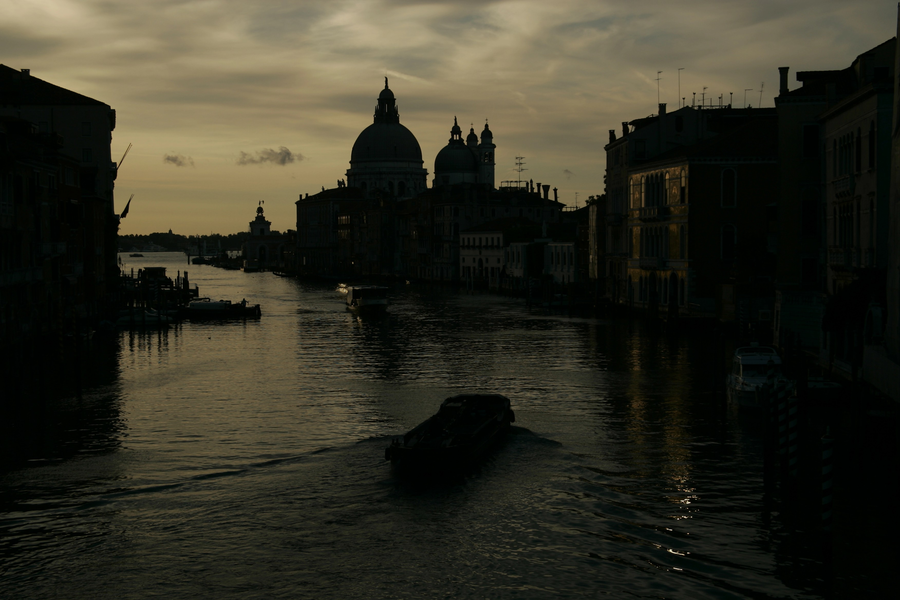

Showing: venice.jpg | exposure=0.005555555555555556 s | size=(3504, 2336) | mode=RGB


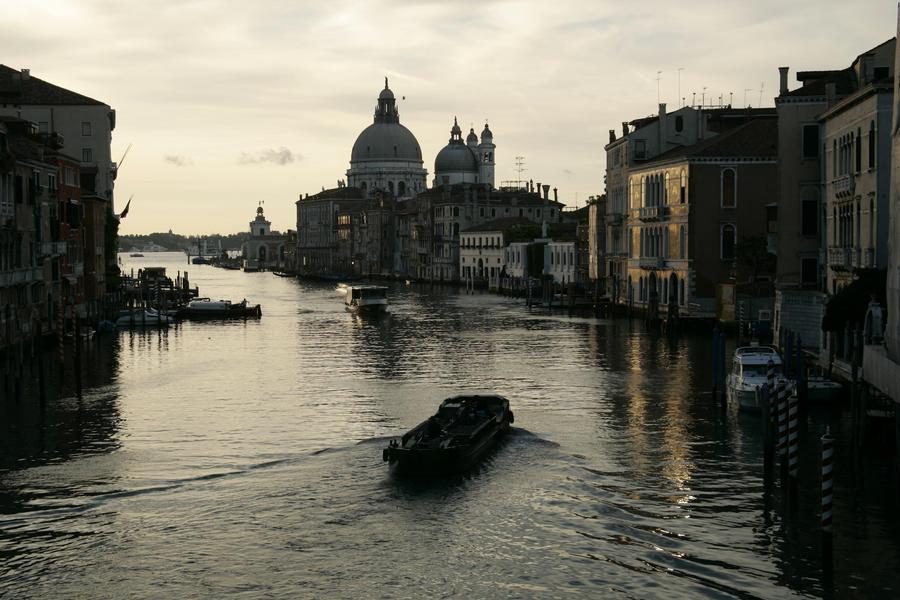

Showing: venice_over.jpg | exposure=0.022222222222222223 s | size=(3504, 2336) | mode=RGB


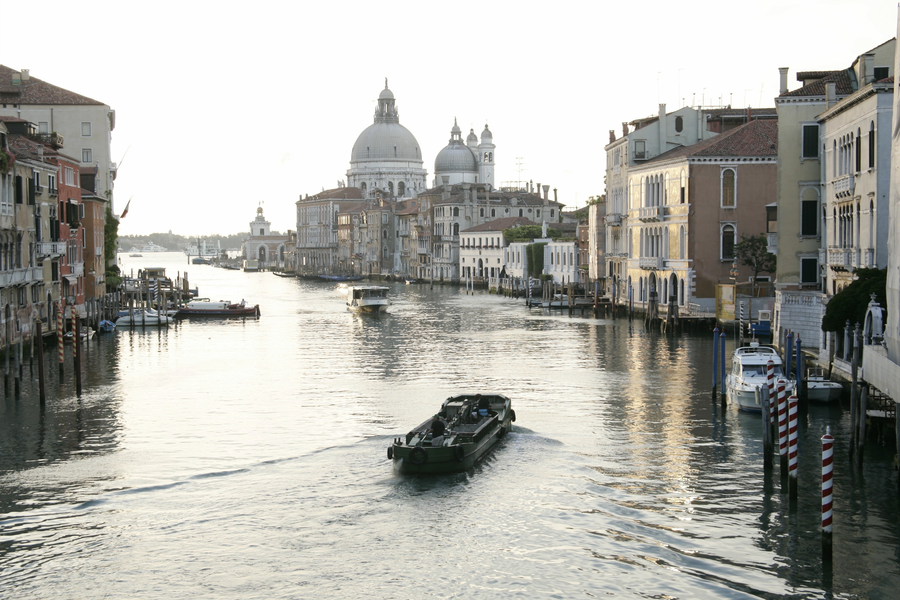

In [9]:
# Display previews and basic metadata

for it in items_sorted:
    p = it["path"].name
    t = it["exposure_time_s"]
    size = it["size"]
    mode = it["mode"]
    print(f"Showing: {p} | exposure={t} s | size={size} | mode={mode}")

    # Show a moderately sized preview
    img = it["image"].copy()
    max_w = 900
    if img.width > max_w:
        ratio = max_w / float(img.width)
        img = img.resize((int(img.width * ratio), int(img.height * ratio)), Image.LANCZOS)
    display(img)



In [10]:
# Validation: same resolution, same orientation, correct order

# Same resolution
sizes = [it["size"] for it in items_sorted]
all_same_size = len(set(sizes)) == 1

# Orientation after EXIF fix should be consistent; PIL doesn't expose orientation flag post-fix,
# so we infer by checking width/height pattern matches the first
base_w, base_h = sizes[0]
all_same_orientation = all((w >= h) == (base_w >= base_h) for (w, h) in sizes)

# Exposure order check: monotonic non-decreasing
exposures = [it["exposure_time_s"] for it in items_sorted]
exposures_known = all(e is not None for e in exposures)
monotonic = all(exposures[i] <= exposures[i+1] for i in range(len(exposures)-1)) if exposures_known else False

print("Validation checks:")
print(" - Same resolution:", all_same_size)
print(" - Same orientation:", all_same_orientation)
print(" - Exposure metadata present:", exposures_known)
print(" - Exposure order non-decreasing:", monotonic)

if not all_same_size:
    print("[WARN] Images differ in size. Normalize before alignment/HDR.")
if exposures_known and not monotonic:
    print("[WARN] Exposure order appears inconsistent. Double-check EXIF.")


Validation checks:
 - Same resolution: True
 - Same orientation: True
 - Exposure metadata present: True
 - Exposure order non-decreasing: True


In [11]:
# # Quick EXIF peek (what tags do we have?)
# for path, img, exif in loaded:
#     print(
#         path.name,
#         "ExposureTime:", exif.get("ExposureTime"),
#         "ShutterSpeedValue:", exif.get("ShutterSpeedValue"),
#         "ExposureBiasValue:", exif.get("ExposureBiasValue"),
#     )


In [12]:
# # Robust fallback sorting when EXIF exposure is missing
# from statistics import fmean

# def filename_rank(name: str) -> int:
#     n = name.lower()
#     if "under" in n or "-2" in n or "_-2" in n:
#         return 0  # darkest
#     if "over" in n or "+2" in n or "_+2" in n:
#         return 2  # brightest
#     return 1      # middle/default


# def mean_brightness(pil_img) -> float:
#     g = pil_img.convert("L")
#     # Fast average luminance without numpy
#     return fmean(g.getdata())


# def exposure_sort_key(item):
#     t = item["exposure_time_s"]
#     if t is not None:
#         # Best path: real exposure time available
#         return (0, t)
#     # Fallback A: filename hints (under < normal < over)
#     rank = filename_rank(item["path"].name)
#     # Fallback B: actual measured brightness (darker first)
#     mb = mean_brightness(item["image"])
#     return (1, rank, mb)

# items_sorted = sorted(items, key=exposure_sort_key)
# # 
# print("Ordering (with fallbacks):")
# for i, it in enumerate(items_sorted, 1):
#     print(f" {i}. {it['path'].name}  t={it['exposure_time_s']}")


In [13]:
    # img, exif = load_pil_and_exif(input_folder / "venice.jpg")
    # print("Keys:", sorted(exif.keys())[:30])
    # print("ExposureTime:", exif.get("ExposureTime"))
    # print("ShutterSpeedValue:", exif.get("ShutterSpeedValue"))
    # print("FNumber:", exif.get("FNumber"), "ISO:", exif.get("ISOSpeedRatings") or exif.get("PhotographicSensitivity"))

In [15]:
# EXIF (piexif) extraction + robust fallback sorting (supersedes earlier sorting)
import piexif
from statistics import fmean


def rational_to_float(x):
    if x is None:
        return None
    if isinstance(x, tuple) and len(x) == 2:
        num, den = x
        return None if not den else float(num) / float(den)
    try:
        return float(x)
    except Exception:
        return None


def apex_to_time(apex):
    return 2.0 ** (-apex) if apex is not None else None


def filename_rank(name: str) -> int:
    n = name.lower()
    if "under" in n or "-2" in n or "_-2" in n:
        return 0  # darkest
    if "over" in n or "+2" in n or "_+2" in n:
        return 2  # brightest
    return 1      # middle/default


def mean_brightness(pil_img) -> float:
    g = pil_img.convert("L")
    return fmean(g.getdata())


# Update items with piexif-derived exposure time, ISO, f-number where present
for it in items:
    try:
        ex = piexif.load(str(it["path"]))
        exp = rational_to_float(ex["Exif"].get(piexif.ExifIFD.ExposureTime))
        if exp is None:
            exp = apex_to_time(ex["Exif"].get(piexif.ExifIFD.ShutterSpeedValue))
        it["exposure_time_s"] = exp if exp is not None else it.get("exposure_time_s")
        it["iso"] = ex["Exif"].get(piexif.ExifIFD.ISOSpeedRatings)
        it["fnumber"] = rational_to_float(ex["Exif"].get(piexif.ExifIFD.FNumber))
    except Exception:
        pass


def exposure_sort_key(item):
    t = item["exposure_time_s"]
    if t is not None:
        return (0, t)
    rank = filename_rank(item["path"].name)
    mb = mean_brightness(item["image"])  # darker first
    return (1, rank, mb)

items_sorted = sorted(items, key=exposure_sort_key)

print("Ordering (EXIF when present, otherwise fallbacks):")
for i, it in enumerate(items_sorted, 1):
    print(f" {i}. {it['path'].name}  t={it['exposure_time_s']}  ISO={it.get('iso')}  f/{it.get('fnumber')}")


Ordering (EXIF when present, otherwise fallbacks):
 1. venice_under.jpg  t=0.0013333333333333333  ISO=100  f/6.7
 2. venice.jpg  t=0.005555555555555556  ISO=100  f/6.7
 3. venice_over.jpg  t=0.022222222222222223  ISO=100  f/6.7


In [16]:
import piexif
ex = piexif.load(str(input_folder / "venice.jpg"))
print("ExposureTime:", ex["Exif"].get(piexif.ExifIFD.ExposureTime))
print("ShutterSpeedValue:", ex["Exif"].get(piexif.ExifIFD.ShutterSpeedValue))
print("FNumber:", ex["Exif"].get(piexif.ExifIFD.FNumber))
print("ISO:", ex["Exif"].get(piexif.ExifIFD.ISOSpeedRatings))

ExposureTime: (1, 180)
ShutterSpeedValue: None
FNumber: (670, 100)
ISO: 100
